In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# arguments
weather_station = 'KDAL'
load_zone = 'COAST'

In [3]:
# connect to database
conn = sqlite3.connect('../test_project.db')

In [4]:
# cant get this to work
#query = 'SELECT ' + weather_station + '.TemperatureF, loads.OperDay_HourEnding_UTC, loads.' + load_zone + ' from ' + weather_station + ' LEFT OUTER JOIN ' + 'loads ON DATE(loads.OperDay_HourEnding_UTC) = DATE(' + weather_station + ".DateUTC) WHERE STRFTIME('%H', loads.OperDay_HourEnding_UTC) = STRFTIME('%H', " + weather_station + '.DateUTC)'
#df = pd.read_sql_query(query, conn)

In [5]:
# load 2014 load data
load_query = 'SELECT OperDay_HourEnding_UTC, ' + load_zone + " from loads WHERE STRFTIME('%Y', loads.OperDay_HourEnding_UTC) = '2014'"
load_df = pd.read_sql_query(load_query, conn)

In [6]:
# load 2014 weather data
weather_query = 'SELECT DateUTC, TemperatureF from ' + weather_station + " WHERE STRFTIME('%Y', " + weather_station + ".DateUTC) = '2014'"
weather_df = pd.read_sql_query(weather_query, conn)

In [7]:
# load 2015 load data
load2015_query = 'SELECT OperDay_HourEnding_UTC, ' + load_zone + " from loads WHERE STRFTIME('%Y', loads.OperDay_HourEnding_UTC) = '2015'"
load2015_df = pd.read_sql_query(load2015_query, conn)

In [8]:
# load 2015 weather data
weather2015_query = 'SELECT DateUTC, TemperatureF from ' + weather_station + " WHERE STRFTIME('%Y', " + weather_station + ".DateUTC) = '2015'"
weather2015_df = pd.read_sql_query(weather2015_query, conn)

In [9]:
# change datatypes

load_df = load_df.astype({'OperDay_HourEnding_UTC': 'datetime64[ns]'})
load_df = load_df.sort_values('OperDay_HourEnding_UTC')
load2015_df = load2015_df.astype({'OperDay_HourEnding_UTC': 'datetime64[ns]'})
load2015_df = load2015_df.sort_values('OperDay_HourEnding_UTC')


weather_df = weather_df.astype({'DateUTC': 'datetime64[ns]'})
weather_df = weather_df.sort_values('DateUTC')
weather2015_df = weather2015_df.astype({'DateUTC': 'datetime64[ns]'})
weather2015_df = weather2015_df.sort_values('DateUTC')

In [10]:
# join load and weather dataframes by date

merged_df = pd.merge_asof(load_df,weather_df, left_on='OperDay_HourEnding_UTC',right_on='DateUTC', tolerance=pd.Timedelta('15min'))
merged_df.dropna(inplace=True)

In [11]:
# drop outlier datapoints from train data

outlier_index = merged_df[merged_df['TemperatureF'] < -100].index
merged_df.drop(outlier_index, inplace=True)

In [12]:
# group df by date to find daily peak load

max_load_df = merged_df.loc[merged_df.groupby(merged_df['OperDay_HourEnding_UTC'].dt.date)[load_zone].idxmax()]

In [13]:
# merge 2015 dataframes by date

test_df = pd.merge_asof(load2015_df,weather2015_df, left_on='OperDay_HourEnding_UTC',right_on='DateUTC', tolerance=pd.Timedelta('15min'))
test_df.dropna(inplace=True)

# group df by date to find daily peak load

test_df = test_df.loc[test_df.groupby(test_df['OperDay_HourEnding_UTC'].dt.date)[load_zone].idxmax()]

In [14]:
# drop outlier datapoints from test data

outlier_index = test_df[test_df['TemperatureF'] < -100].index
test_df.drop(outlier_index, inplace=True)

In [15]:
# fit 2014 data

coeffs = np.polyfit(max_load_df['TemperatureF'], max_load_df[load_zone], 2)
model = np.poly1d(coeffs)

In [16]:
# save .csv file of model predictions by date 

model_predictions = np.polyval(coeffs, test_df['TemperatureF'])
predict_df = test_df
predict_df['load_predictions'] = model_predictions.tolist()
predict_df = pd.concat([predict_df['DateUTC'].dt.date, predict_df['load_predictions']], axis=1)
predict_df.to_csv('model_predictions.csv')

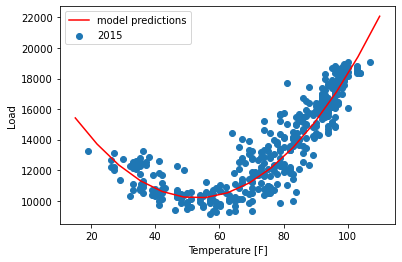

In [17]:
x_range = np.linspace(15, 110, 15)
plt.plot(x_range, model(x_range), label='model predictions', color='red')
plt.scatter(test_df['TemperatureF'], test_df[load_zone], label='2015')
plt.xlabel('Temperature [F]')
plt.ylabel('Load')
plt.legend()
plt.savefig('model_predictions_2015.pdf')

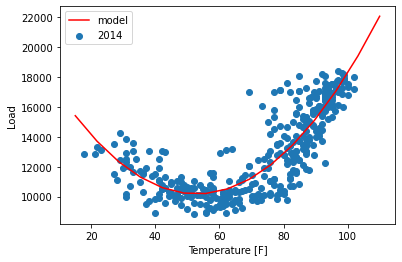

In [18]:
x_range = np.linspace(15, 110, 15)
plt.scatter(max_load_df['TemperatureF'], max_load_df[load_zone], label='2014')
plt.plot(x_range, model(x_range), color='red', label='model')
plt.xlabel('Temperature [F]')
plt.ylabel('Load')
plt.legend()

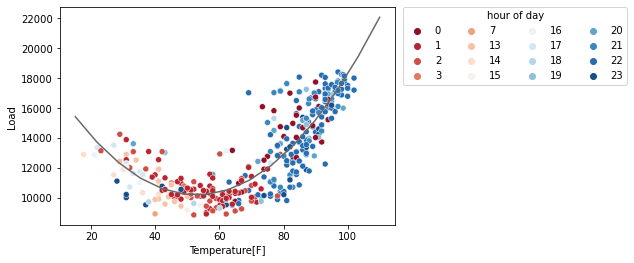

In [66]:
fig, ax = plt.subplots()
colors = sns.color_palette('RdBu', len(max_load_df['OperDay_HourEnding_UTC'].dt.hour.unique()))
sns.scatterplot(data=max_load_df, x='TemperatureF', y=load_zone, hue=max_load_df['OperDay_HourEnding_UTC'].dt.hour, palette=colors)
sns.lineplot(x=x_range, y=model(x_range), color='dimgray')

ax.set_xlabel('Temperature[F]')
ax.set_ylabel('Load')

ax.legend_.remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='hour of day', ncol=4, bbox_to_anchor=(1.45,0.9))

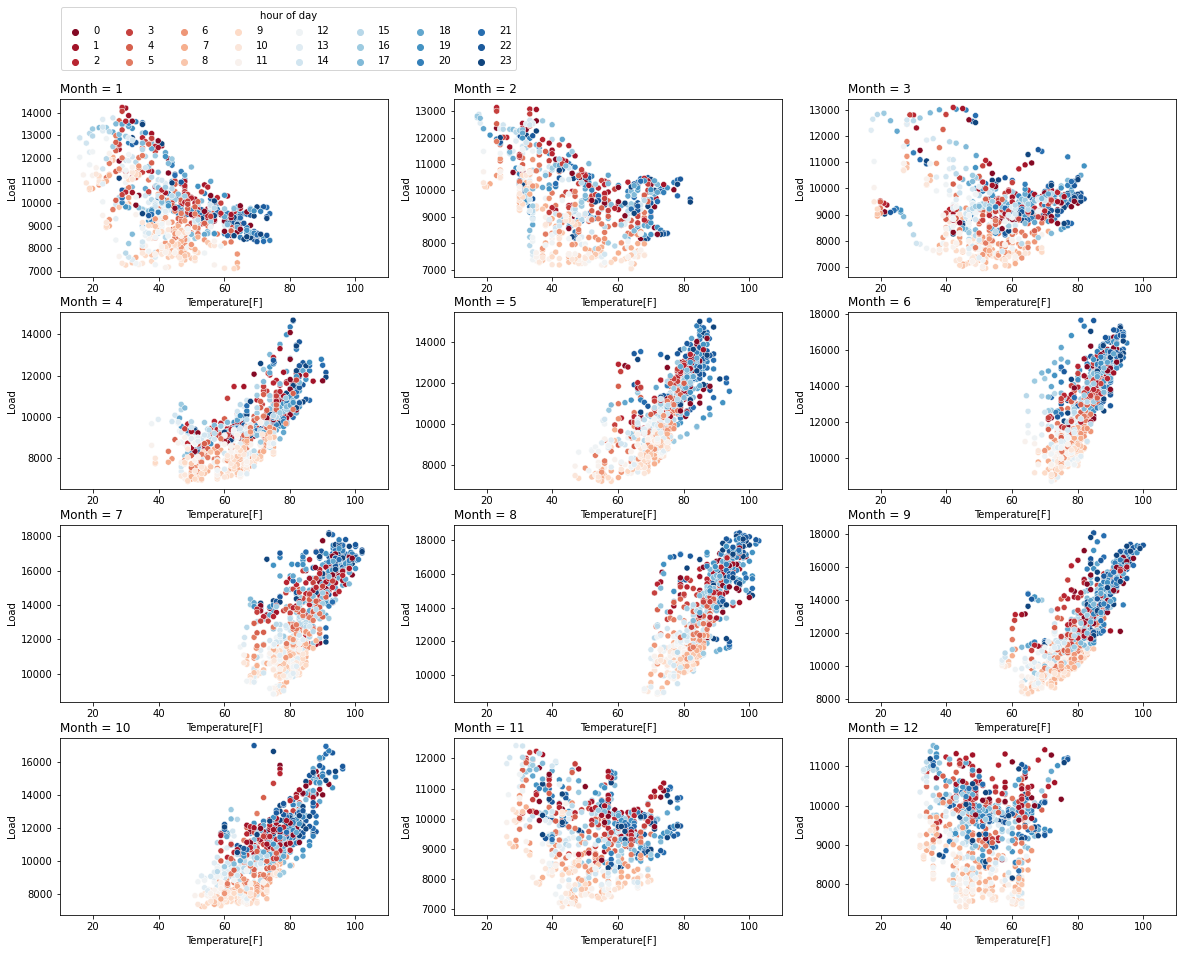

In [21]:
# plot hourly temperatures vs load by month

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
ax = ax.flatten()
colors = sns.color_palette('RdBu', len(merged_load_df['OperDay_HourEnding_UTC'].dt.hour.unique()))

months = merged_df['OperDay_HourEnding_UTC'].dt.month.unique()

for x in months:
    monthly_df = merged_df.loc[merged_df['OperDay_HourEnding_UTC'].dt.month == x]
    sns.scatterplot(data=monthly_df, x='TemperatureF', y=load_zone, hue=monthly_df['OperDay_HourEnding_UTC'].dt.hour, palette=colors, ax=ax[x-1])
    ax[x-1].legend_.remove()
    ax[x-1].set_title('Month = ' + str(x), loc='Left')
    ax[x-1].set_xlabel('Temperature[F]')
    ax[x-1].set_ylabel('Load')
    ax[x-1].set_xlim([10,110])
handles, labels = ax[x-1].get_legend_handles_labels()
fig.legend(handles, labels, title='hour of day', ncol=8, bbox_to_anchor=(0.445,0.97))

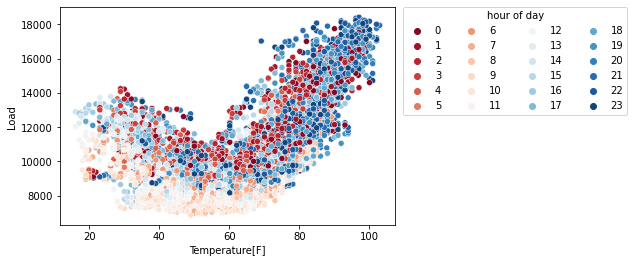

In [69]:
# plot hourly temperature vs load across full year, colored by hour of day
fig, ax = plt.subplots()
colors = sns.color_palette('RdBu', len(merged_df['OperDay_HourEnding_UTC'].dt.hour.unique()))
sns.scatterplot(data=merged_df, x='TemperatureF', y=load_zone, hue=merged_df['OperDay_HourEnding_UTC'].dt.hour, palette=colors)

ax.set_xlabel('Temperature[F]')
ax.set_ylabel('Load')

ax.legend_.remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='hour of day', ncol=4, bbox_to_anchor=(1.45,0.9))